In [ ]:
!pip install dash-bootstrap-components

     |████████████████████████████████| 207 kB 5.4 MB/s 
     |████████████████████████████████| 7.3 MB 37.7 MB/s 
     |████████████████████████████████| 23.9 MB 43.5 MB/s 
     |████████████████████████████████| 357 kB 44.1 MB/s 
  Created wheel for dash-core-components: filename=dash_core_components-2.0.0-py3-none-any.whl size=3821 sha256=6e50dd99a26d3e3945492fbfece80deeb508ee463328016c7360b581d5a631b9
  Stored in directory: /root/.cache/pip/wheels/00/f9/c7/1a6437d794ed753ea9bc9079e761d4fc803a1f1f5d3697b9ec
  Created wheel for dash-html-components: filename=dash_html_components-2.0.0-py3-none-any.whl size=4089 sha256=dd6d9ec06970e02daf7b5b682267b62f25fb7392665989ab803d7bcaac76f28e
  Stored in directory: /root/.cache/pip/wheels/ec/6b/81/05aceabd8b27f724e2c96784016287cc1bfbc349ebfda451de
  Created wheel for dash-table: filename=dash_table-5.0.0-py3-none-any.whl size=3911 sha256=4f930e245c62b54a936c2ef02a6015811fa05d7095b608682885b8615eed983e
  Stored in directory: /root/.cache/pip/whe

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install dash-core-components

In [ ]:
!pip install scikit-learn

In [ ]:
!pip install gunicorn

     |████████████████████████████████| 79 kB 3.5 MB/s 


In [ ]:
import dash
import matplotlib
import numpy
import pandas
import plotly
import scipy
import xgboost
import gunicorn

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

pd.options.mode.chained_assignment = None


def data_preprocessing():
    df = pd.read_csv("data/SCADA_data.csv")
    status_data_wec = pd.read_csv("data/status_data_wec.csv")

    df["Inverter avg. temp"] = df[
        [
            "CS101 : Sys 1 inverter 1 cabinet temp.",
            "CS101 : Sys 1 inverter 2 cabinet temp.",
            "CS101 : Sys 1 inverter 3 cabinet temp.",
            "CS101 : Sys 1 inverter 4 cabinet temp.",
            "CS101 : Sys 1 inverter 5 cabinet temp.",
            "CS101 : Sys 1 inverter 6 cabinet temp.",
            "CS101 : Sys 1 inverter 7 cabinet temp.",
            "CS101 : Sys 2 inverter 1 cabinet temp.",
            "CS101 : Sys 2 inverter 2 cabinet temp.",
            "CS101 : Sys 2 inverter 3 cabinet temp.",
            "CS101 : Sys 2 inverter 4 cabinet temp.",
        ]
    ].mean(axis=1)
    df["Inverter std. temp"] = df[
        [
            "CS101 : Sys 1 inverter 1 cabinet temp.",
            "CS101 : Sys 1 inverter 2 cabinet temp.",
            "CS101 : Sys 1 inverter 3 cabinet temp.",
            "CS101 : Sys 1 inverter 4 cabinet temp.",
            "CS101 : Sys 1 inverter 5 cabinet temp.",
            "CS101 : Sys 1 inverter 6 cabinet temp.",
            "CS101 : Sys 1 inverter 7 cabinet temp.",
            "CS101 : Sys 2 inverter 1 cabinet temp.",
            "CS101 : Sys 2 inverter 2 cabinet temp.",
            "CS101 : Sys 2 inverter 3 cabinet temp.",
            "CS101 : Sys 2 inverter 4 cabinet temp.",
        ]
    ].std(axis=1)
    df["Time"] = pd.to_datetime(df["Time"], dayfirst=True, errors="coerce")
    df.sort_values(by="Time", axis=0, inplace=True)
    df.reset_index(drop=True, inplace=True)

    af_corr_time_wec_s = status_data_wec.loc[
        (status_data_wec["Main Status"] == 62)
        | (status_data_wec["Main Status"] == 80)
        | (status_data_wec["Main Status"] == 228)
        | (status_data_wec["Main Status"] == 60)
        | (status_data_wec["Main Status"] == 9),
        "Time",
    ]

    af_corr_time_wec_s = pd.to_datetime(af_corr_time_wec_s)
    af_corr_time_wes = af_corr_time_wec_s.round("10min")

    df.rename(columns={"Error": "Fault"}, inplace=True)
    df["Fault"] = [0] * len(df)
    for i, d in enumerate(df["Time"]):
        if d in af_corr_time_wes.values:
            df["Fault"][i] = 1

    nf_times = []
    rul = []
    for i, d in enumerate(df["Fault"]):
        nf_times.append(df["Time"][i])
        if d == 1:
            for j in nf_times:
                rul.append(df["Time"][i] - j)
            nf_times = []

    df_trimmed = df.head(len(rul))

    rul_days = [x.days for x in rul]
    df_trimmed["RUL"] = rul_days

    cols_to_drop = [
        "Fault",
        "CS101 : Sys 1 inverter 1 cabinet temp.",
        "CS101 : Sys 1 inverter 2 cabinet temp.",
        "CS101 : Sys 1 inverter 3 cabinet temp.",
        "CS101 : Sys 1 inverter 4 cabinet temp.",
        "CS101 : Sys 1 inverter 5 cabinet temp.",
        "CS101 : Sys 1 inverter 6 cabinet temp.",
        "CS101 : Sys 1 inverter 7 cabinet temp.",
        "CS101 : Sys 2 inverter 1 cabinet temp.",
        "CS101 : Sys 2 inverter 2 cabinet temp.",
        "CS101 : Sys 2 inverter 3 cabinet temp.",
        "CS101 : Sys 2 inverter 4 cabinet temp.",
    ]

    for i in cols_to_drop:
        if i in list(df):
            df_trimmed.drop(i, axis=1, inplace=True)

    df_trimmed = df_trimmed.head(39298)
    df_trimmed.set_index("Time", inplace=True)

    df = df_trimmed.copy()
    features = df.columns.tolist()
    timesteps = 5

    df_list = [
        df[features].shift(shift_val)
        if (shift_val == 0)
        else df[features].shift(-shift_val).add_suffix(f"_{shift_val}")
        for shift_val in range(0, timesteps)
    ]
    df_concat = pd.concat(df_list, axis=1, sort=False)
    df_concat = df_concat.iloc[:-timesteps, :]

    target = "RUL"
    x_train, x_test, y_train, y_test = train_test_split(
        df_concat,
        df[target].iloc[:-timesteps],
        test_size=0.02642894598,
        random_state=10,
        shuffle=False,
    )

    df_test = x_test.iloc[:, : df.shape[1]]

    return df, df_test, x_test, y_test, x_train



In [ ]:
{
    "scripts": {
        "dokku": {
            "predeploy": "bash predeploy.sh"
        }
    }
}

{'scripts': {'dokku': {'predeploy': 'bash predeploy.sh'}}}

In [ ]:
!apt-get -qq install -y dash && pip install -U dash



In [ ]:
!pip install dash_bootstrap_components

In [ ]:
!pip install dash_daq

     |████████████████████████████████| 642 kB 5.2 MB/s 
  Created wheel for dash-daq: filename=dash_daq-0.5.0-py3-none-any.whl size=669716 sha256=150ccc749c895c828256cd7406cf8b2223d86c20f7d812c8c514659580da5b49
  Stored in directory: /root/.cache/pip/wheels/fe/54/53/a8d448db5592874db4313240571ca2c069e55f6a6b29bf5847
Successfully built dash-daq


In [ ]:
import dash
from dash import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import plotly.graph_objs as go
import psycopg2
import os
import flask


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [ ]:
#app.run_server(host='0.0.0.0', port=8050, debug=True)

In [ ]:
#app.run_server(host='0.0.0.0', debug=True)

In [ ]:
!pip install data_preprocessing

  Created wheel for data-preprocessing: filename=data_preprocessing-0.0.2-py3-none-any.whl size=4838 sha256=af095f448ed022c32a64e63080a1ef1af48a0565e395d174fd9f7a680d5de74b
  Stored in directory: /root/.cache/pip/wheels/d2/43/01/68e44dc30445fdc00258dde46da495f4a925379a3071cf102e
Successfully built data-preprocessing


In [ ]:
import pandas as pd
import dash
import dash_bootstrap_components as dbc
import dash_core_components as dcc
import dash_html_components as html
import dash_daq as daq

import plotly.graph_objs as go
from dash.dependencies import Input, Output, State
from datetime import datetime, date
from data_preprocessing import data_preprocessing
import pickle

app = dash.Dash(
    __name__,
    meta_tags=[{"name": "viewport", "content": "width=device-width, initial-scale=1"}],
    external_stylesheets=[dbc.themes.CYBORG],
)
server = app.server
app.title = "Predictive Maintenance Dashboard"


def logo(app):
    title = html.H5(
        "PREDICTIVE MAINTENANCE DASHBOARD FOR WIND TURBINES",
        style={"marginTop": 5, "marginLeft": "10px"},
    )

    info_about_app = html.H6(
        "This Dashboard is focused on estimating the Remaining Useful Life (RUL) in wind turbines via Machine Learning."
        " RUL is defined as the time until the next fault and estimated via XGBoost algorithm.",
        style={"marginLeft": "10px"},
    )

    logo_image = html.Img(
        src=app.get_asset_url("dash-logo.png"), style={"float": "right", "height": 50}
    )
    link = html.A(logo_image, href="https://plotly.com/dash/")

    return dbc.Row(
        [dbc.Col([dbc.Row([title]), dbc.Row([info_about_app])]), dbc.Col(link)]
    )


df, df_button, x_test, y_test, x_train = data_preprocessing()

predict_button = dbc.Card(
    className="mt-auto",
    children=[
        dbc.CardBody(
            [
                html.Div(
                    [
                        dbc.Button(
                            "Predict",
                            id="predict-button",
                            color="primary",
                            outline=True,
                            size="lg",
                            style={"color": "#fec036"},
                        ),
                    ]
                )
            ],
            style={
                "text-align": "center",
                "backgroundColor": "black",
                "border-radius": "1px",
                "border-width": "5px",
                "border-top": "1px solid rgb(216, 216, 216)",
                "border-left": "1px solid rgb(216, 216, 216)",
                "border-right": "1px solid rgb(216, 216, 216)",
                "border-bottom": "1px solid rgb(216, 216, 216)",
            },
        )
    ],
)

get_new_information_button = dbc.Card(
    className="mt-auto",
    children=[
        dbc.CardBody(
            [
                html.Div(
                    [
                        dbc.Button(
                            "Get New Data",
                            id="get-new-info-button",
                            color="primary",
                            outline=True,
                            size="lg",
                            style={"color": "#fec036"},
                        ),
                    ]
                )
            ],
            style={
                "text-align": "center",
                "backgroundColor": "black",
                "border-radius": "1px",
                "border-width": "5px",
                "border-top": "1px solid rgb(216, 216, 216)",
                "border-left": "1px solid rgb(216, 216, 216)",
                "border-right": "1px solid rgb(216, 216, 216)",
                "border-bottom": "1px solid rgb(216, 216, 216)",
            },
        )
    ],
)

graphs = dbc.Card(
    children=[
        dbc.CardBody(
            [
                html.Div(
                    [
                        dcc.Graph(
                            id="Main-Graph",
                            figure={
                                "layout": {
                                    "margin": {"t": 30, "r": 35, "b": 40, "l": 50},
                                    "xaxis": {
                                        "dtick": 5,
                                        "gridcolor": "#636363",
                                        "showline": False,
                                    },
                                    "yaxis": {"showgrid": False, "showline": False},
                                    "plot_bgcolor": "black",
                                    "paper_bgcolor": "black",
                                    "font": {"color": "gray"},
                                },
                            },
                            config={"displayModeBar": False},
                        ),
                        html.Pre(id="update-on-click-data"),
                    ],
                    style={"width": "98%", "display": "inline-block"},
                ),
                html.Div(
                    [
                        dcc.Dropdown(
                            id="feature-dropdown",
                            options=[
                                {"label": label, "value": label} for label in df.columns
                            ],
                            value="",
                            multi=False,
                            searchable=False,
                        )
                    ],
                    style={
                        "width": "33%",
                        "display": "inline-block",
                        "color": "black",
                    },
                ),
                html.Div(
                    [
                        dcc.DatePickerRange(
                            id="date-picker",
                            min_date_allowed=x_train.index[0],  # need to change this
                            max_date_allowed=x_train.index[-1],
                            initial_visible_month=x_train.index[0],
                            start_date_placeholder_text="Start Period",
                            end_date_placeholder_text="End Period",
                            calendar_orientation="vertical",
                        ),
                        html.Div(id="output-container-date-picker-range"),
                    ],
                    style={
                        "vertical-align": "top",
                        "position": "absolute",
                        "right": "3%",
                        "float": "right",
                        "display": "inline-block",
                        "color": "black",
                    },
                ),
            ],
            style={
                "backgroundColor": "black",
                "border-radius": "1px",
                "border-width": "5px",
                "border-top": "1px solid rgb(216, 216, 216)",
            },
        )
    ]
)

rul_estimation_indicator = dbc.Card(
    children=[
        dbc.CardHeader(
            "System RUL Estimation (days)",
            style={
                "text-align": "center",
                "color": "white",
                "backgroundColor": "black",
                "border-radius": "1px",
                "border-width": "5px",
                "border-top": "1px solid rgb(216, 216, 216)",
            },
        ),
        dbc.CardBody(
            [
                daq.LEDDisplay(
                    id="rul-estimation-indicator-led",
                    size=24,
                    color="#fec036",
                    style={"color": "#black"},
                    backgroundColor="#2b2b2b",
                    value="0.0",
                )
            ],
            style={
                "text-align": "center",
                "backgroundColor": "black",
                "border-radius": "1px",
                "border-width": "5px",
                "border-top": "1px solid rgb(216, 216, 216)",
            },
        ),
    ]
)

info_box = dbc.Card(
    children=[
        dbc.CardBody(
            [
                html.Div(
                    dcc.Textarea(
                        id="Info-Textbox",
                        placeholder="This field is used to display information about a feature displayed "
                                    "on the graph and estimated RUL. In order to estimate the RUL, use "
                                    "the button 'Get New Data' and then, 'Predict'. The estimated RUL will be "
                                    "printed.",
                        rows=8,
                        style={
                            "width": "100%",
                            "height": "100%",
                            "background-color": "black",
                            "color": "#fec036",
                            "placeholder": "#fec036",
                            "fontFamily": "Arial",
                            "fontSize": "16",
                            "padding": "12px",
                            "display": "inline-block",
                        },
                    )
                )
            ],
            style={
                "backgroundColor": "black",
                "border-radius": "1px",
                "border-width": "5px",
                "border-top": "1px solid rgb(216, 216, 216)",
            },
        ),
    ],
)

blade_angle_display = dbc.Card(
    children=[
        dbc.CardHeader(
            "Blade Angle",
            style={
                "text-align": "center",
                "color": "white",
                "backgroundColor": "black",
                "border-radius": "1px",
                "border-width": "5px",
                "border-top": "1px solid rgb(216, 216, 216)",
            },
        ),
        dbc.CardBody(
            [
                html.Div(
                    daq.Gauge(
                        id="blade-angle-information-gauge",
                        min=min(df["WEC: ava. blade angle A"]),
                        max=max(
                            df["WEC: ava. blade angle A"]
                        ),
                        value=0,
                        showCurrentValue=True,
                        color="#fec036",
                        style={
                            "align": "center",
                            "display": "flex",
                            "marginTop": "5%",
                            "marginBottom": "-10%",
                        },
                    ),
                    className="m-auto",
                    style={
                        "display": "flex",
                        "backgroundColor": "black",
                        "border-radius": "1px",
                        "border-width": "5px",
                    },
                )
            ],
            className="d-flex",
            style={
                "backgroundColor": "black",
                "border-radius": "1px",
                "border-width": "5px",
                "border-top": "1px solid rgb(216, 216, 216)",
            },
        ),
    ],
    style={"height": "95%"},
)

active_power_display = dbc.Card(
    children=[
        dbc.CardHeader(
            "Active Power [kW]",
            style={
                "text-align": "center",
                "color": "white",
                "backgroundColor": "black",
                "border-radius": "1px",
                "border-width": "5px",
                "border-top": "1px solid rgb(216, 216, 216)",
            },
        ),
        dbc.CardBody(
            [
                html.Div(
                    daq.Gauge(
                        id="active-power-information-gauge",
                        min=min(df["WEC: ava. Power"]),
                        max=max(
                            df["WEC: ava. Power"]
                        ),  # This one should be the theoretical maximum
                        value=100,
                        showCurrentValue=True,
                        color="#fec036",
                        style={
                            "align": "center",
                            "display": "flex",
                            "marginTop": "5%",
                            "marginBottom": "-10%",
                        },
                    ),
                    className="m-auto",
                    style={
                        "display": "flex",
                        "backgroundColor": "black",
                        "border-radius": "1px",
                        "border-width": "5px",
                    },
                )
            ],
            className="d-flex",
            style={
                "backgroundColor": "black",
                "border-radius": "1px",
                "border-width": "5px",
                "border-top": "1px solid rgb(216, 216, 216)",
            },
        ),
    ],
    style={"height": "95%"},
)

active_power_from_wind_display = dbc.Card(
    children=[
        dbc.CardHeader(
            "Active Power Available from Wind [kW]",
            style={
                "display": "inline-block",
                "text-align": "center",
                "color": "white",
                "backgroundColor": "black",
                "border-radius": "1px",
                "border-width": "5px",
                "border-top": "1px solid rgb(216, 216, 216)",
            },
        ),
        dbc.CardBody(
            [
                html.Div(
                    daq.Gauge(
                        id="active-power-from-wind-information-gauge",
                        min=min(df["WEC: ava. available P from wind"]),
                        max=max(df["WEC: ava. available P from wind"]),
                        value=10,
                        showCurrentValue=True,
                        color="#fec036",
                        style={
                            "align": "center",
                            "display": "flex",
                            "marginTop": "5%",
                            "marginBottom": "-10%",
                        },
                    ),
                    className="m-auto",
                    style={
                        "display": "flex",
                        "backgroundColor": "black",
                        "border-radius": "1px",
                        "border-width": "5px",
                    },
                )
            ],
            className="d-flex",
            style={
                "backgroundColor": "black",
                "border-radius": "1px",
                "border-width": "5px",
                "border-top": "1px solid rgb(216, 216, 216)",
            },
        ),
    ],
    style={"height": "95%"},
)

wind_speed_information = dbc.Card(
    className="mt-auto",
    children=[
        dbc.CardHeader(
            "Wind Speed [m/s]",
            style={
                "text-align": "center",
                "color": "white",
                "backgroundColor": "black",
                "border-radius": "1px",
                "border-width": "5px",
                "border-top": "1px solid rgb(216, 216, 216)",
            },
        ),
        dbc.CardBody(
            [
                html.Div(
                    daq.Gauge(
                        id="wind-power-information-gauge",
                        min=min(df["WEC: ava. windspeed"]),
                        max=int(max(df["WEC: ava. windspeed"])),
                        value=0,
                        showCurrentValue=True,
                        color="#fec036",
                        style={
                            "align": "center",
                            "display": "flex",
                            "marginTop": "5%",
                            "marginBottom": "-10%",
                        },
                    ),
                    className="m-auto",
                    style={
                        "display": "flex",
                        "backgroundColor": "black",
                        "border-radius": "1px",
                        "border-width": "5px",
                    },
                )
            ],
            className="d-flex",
            style={
                "backgroundColor": "black",
                "border-radius": "1px",
                "border-width": "5px",
                "border-top": "1px solid rgb(216, 216, 216)",
            },
        ),
    ],
    style={"height": "95%"},
)

reactive_power_display = dbc.Card(
    className="mt-auto",
    children=[
        dbc.CardHeader(
            "Reactive Power [kVAR]",
            style={
                "text-align": "center",
                "color": "white",
                "backgroundColor": "black",
                "border-radius": "1px",
                "border-width": "5px",
                "border-top": "1px solid rgb(216, 216, 216)",
            },
        ),
        dbc.CardBody(
            [
                html.Div(
                    daq.Gauge(
                        id="reactive-power-information-gauge",
                        min=min(df["WEC: ava. reactive Power"]),
                        max=max(df["WEC: ava. reactive Power"]),
                        value=0,
                        showCurrentValue=True,
                        color="#fec036",
                        style={
                            "align": "center",
                            "display": "flex",
                            "marginTop": "5%",
                            "marginBottom": "-10%",
                        },
                    ),
                    className="m-auto",
                    style={
                        "display": "flex",
                        "backgroundColor": "black",
                        "border-radius": "1px",
                        "border-width": "5px",
                    },
                )
            ],
            className="d-flex",
            style={
                "backgroundColor": "black",
                "border-radius": "1px",
                "border-width": "5px",
                "border-top": "1px solid rgb(216, 216, 216)",
            },
        ),
    ],
    style={"height": "95%"},
)

gauge_size = "auto"
sidebar_size = 12
graph_size = 10
app.layout = dbc.Container(
    fluid=True,
    children=[
        logo(app),
        dbc.Row(
            [
                dbc.Col(
                    [
                        dbc.Row(dbc.Col(rul_estimation_indicator,
                                        xs=sidebar_size,
                                        md=sidebar_size,
                                        lg=sidebar_size,
                                        width=sidebar_size)
                                ),
                        dbc.Row(dbc.Col(info_box,
                                        xs=sidebar_size,
                                        md=sidebar_size,
                                        lg=sidebar_size,
                                        width=sidebar_size)
                                ),
                        dbc.Row(dbc.Col(get_new_information_button,
                                        xs=sidebar_size,
                                        md=sidebar_size,
                                        lg=sidebar_size,
                                        width=sidebar_size)
                                ),
                        dbc.Row(dbc.Col(predict_button,
                                        xs=sidebar_size,
                                        md=sidebar_size,
                                        lg=sidebar_size,
                                        width=sidebar_size)
                                ),
                    ]
                ),
                dbc.Col(graphs,
                        xs=graph_size,
                        md=graph_size,
                        lg=graph_size,
                        width=graph_size)
            ],
            # justify='start',
            style={
                "display": "flex",
                "marginBottom": "-3%"
                   },
        ),
        dbc.Row(
            [
                dbc.Col(active_power_display,
                        xs=gauge_size,
                        md=gauge_size,
                        lg=gauge_size,
                        width=gauge_size),
                dbc.Col(active_power_from_wind_display,
                        xs=gauge_size,
                        md=gauge_size,
                        lg=gauge_size,
                        width=gauge_size),
                dbc.Col(reactive_power_display,
                        xs=gauge_size,
                        md=gauge_size,
                        lg=gauge_size,
                        width=gauge_size),
                dbc.Col(wind_speed_information,
                        xs=gauge_size,
                        md=gauge_size,
                        lg=gauge_size,
                        width=gauge_size),
                dbc.Col(blade_angle_display,
                        xs=gauge_size,
                        md=gauge_size,
                        lg=gauge_size,
                        width=gauge_size),
            ],
            justify='end',
            style={
                "marginTop": "3%"
            },
        ),
    ],
)


def fig_update_layout(fig):
    fig.update_layout(
        xaxis=dict(
            showline=False,
            showgrid=False,
            showticklabels=True,
            zeroline=False,
            gridcolor="#636363",
            linecolor="rgb(204, 204, 204)",
            linewidth=2,
            tickfont=dict(family="Arial", size=12, color="white", ),
            title=dict(font=dict(family="Arial", size=24, color="#fec036"), ),
        ),
        yaxis=dict(
            showline=False,
            showgrid=False,
            showticklabels=True,
            zeroline=False,
            gridcolor="#636363",
            linecolor="rgb(204, 204, 204)",
            linewidth=2,
            tickfont=dict(family="Arial", size=12, color="white", ),
            title=dict(font=dict(family="Arial", size=24, color="#fec036"), ),
        ),
        autosize=True,
        margin=dict(autoexpand=True, l=50, b=40, r=35, t=30),
        showlegend=False,
        paper_bgcolor="black",
        plot_bgcolor="black",
        title=dict(
            font=dict(family="Arial", size=32, color="darkgray"),
            xanchor="center",
            yanchor="top",
            y=1,
            x=0.5,
        ),
    )
    return fig


@app.callback(
    [
        Output("Main-Graph", "figure"),
        Output("rul-estimation-indicator-led", "value"),
        Output("Info-Textbox", "value"),
    ],
    [
        Input("feature-dropdown", "value"),
        Input("date-picker", "start_date"),
        Input("date-picker", "end_date"),
        Input("get-new-info-button", "n_clicks"),
        Input("predict-button", "n_clicks"),
    ],
)
def update_graph(selected_column, start_date, end_date, n_get_new_info, n_pred):
    if n_pred is None:  # here is my work before prediction button is activated.
        value_rul = 0.0
        information_update = (
            "This field is used to display information about a feature displayed "
            "on the graph and estimated RUL. In order to estimate the RUL, use "
            "the button 'Get New Data' and then, 'Predict'. The estimated RUL will be "
            "printed."
        )
        if n_get_new_info is None:
            if selected_column in list(df):
                if start_date and end_date:
                    start_date_object = datetime.strptime(start_date, "%Y-%m-%d")
                    end_date_object = datetime.strptime(end_date, "%Y-%m-%d")
                    mask = (df.index > start_date_object) & (
                            df.index <= end_date_object
                    )
                    df_within_dates = df.loc[mask]
                    fig = go.Figure(
                        data=[
                            go.Scatter(
                                x=df_within_dates.index,
                                y=df_within_dates[selected_column],
                            )
                        ]
                    )
                    fig = fig_update_layout(fig)
                    return fig, value_rul, information_update
                elif start_date:
                    start_date_object = datetime.strptime(start_date, "%Y-%m-%d")
                    mask = df.index > start_date_object
                    df_within_dates = df.loc[mask]
                    fig = go.Figure(
                        data=[
                            go.Scatter(
                                x=df_within_dates.index,
                                y=df_within_dates[selected_column],
                            )
                        ]
                    )
                    fig = fig_update_layout(fig)
                    return fig, value_rul, information_update
                else:
                    fig = go.Figure(
                        data=[go.Scatter(x=df.index, y=df[selected_column])]
                    )
                    fig = fig_update_layout(fig)
                    return fig, value_rul, information_update
            else:
                fig = go.Figure(
                    data=[go.Scatter(x=df.index, y=df["WEC: ava. windspeed"])]
                )
                fig = fig_update_layout(fig)
                return fig, value_rul, information_update
        else:
            _information_update = (
                            "New information is received for the last week and covers periods from "
                            + str(df_button.index[0])
                            + " to "
                            + str(df_button.index[-1])
                            + ". To predict"
                              " RUL, use 'Predict' button. To view data for the aforementioned period, choose"
                              " appropriate dates on the calendar."
            )
            if selected_column in list(df_button):
                fig = go.Figure(
                    data=[
                        go.Scatter(x=df_button.index, y=df_button[selected_column])
                    ]
                )
                fig = fig_update_layout(fig)
                return fig, value_rul, _information_update
            else:
                fig = go.Figure(
                    data=[
                        go.Scatter(x=df_button.index, y=df_button["WEC: ava. windspeed"])
                    ]
                )
                fig = fig_update_layout(fig)
                return fig, value_rul, _information_update
    else:  # Prediction button is pressed
        if n_get_new_info is None:
            value_rul = 0.0
            information_update = " 'Predict' button will not produce a desired result until new information is received." \
                                 " To predict RUL, please use 'Get New Data' button."
            if selected_column in list(df):
                if start_date and end_date:
                    start_date_object = datetime.strptime(start_date, "%Y-%m-%d")
                    end_date_object = datetime.strptime(end_date, "%Y-%m-%d")
                    mask = (df.index > start_date_object) & (
                        df.index <= end_date_object
                    )
                    df_within_dates = df.loc[mask]
                    fig = go.Figure(
                        data=[
                            go.Scatter(
                                x=df_within_dates.index,
                                y=df_within_dates[selected_column],
                            )
                        ]
                    )
                    fig = fig_update_layout(fig)
                    return fig, value_rul, information_update
                elif start_date:
                    start_date_object = datetime.strptime(start_date, "%Y-%m-%d")
                    mask = df.index > start_date_object
                    df_within_dates = df.loc[mask]
                    fig = go.Figure(
                        data=[
                            go.Scatter(
                                x=df_within_dates.index,
                                y=df_within_dates[selected_column],
                            )
                        ]
                    )
                    fig = fig_update_layout(fig)
                    return fig, value_rul, information_update
                else:
                    fig = go.Figure(
                                data=[go.Scatter(x=df.index, y=df[selected_column])]
                            )
                    fig = fig_update_layout(fig)
                    return fig, value_rul, information_update
            else:
                fig = go.Figure(
                            data=[go.Scatter(x=df.index, y=df["WEC: ava. windspeed"])]
                        )
                fig = fig_update_layout(fig)
                return fig, value_rul, information_update
        else:
            model = pickle.load(open("assets/xgb_reg.pkl", "rb"))
            y_pred = model.predict(x_test)
            df_out = pd.DataFrame()
            df_out["pred"] = y_pred
            value_rul = round(max(df_out["pred"]))
            information_update = "RUL is estimated based on the readings from the last week: " "from " + str(
                x_test.index[0]
            ) + " to " + str(
                x_test.index[-1]
            )
            start_date = df_button.index[0]
            end_date = df_button.index[-1]
            if selected_column in list(df_button):
                fig = go.Figure(
                    data=[
                        go.Scatter(
                            x=df_button.index,
                            y=df_button[selected_column],
                        )
                        ]
                )
                fig = fig_update_layout(fig)
                return fig, value_rul, information_update
            else:
                fig = go.Figure(
                    data=[go.Scatter(x=df.index, y=df_button["WEC: ava. windspeed"])]
                )
                fig = fig_update_layout(fig)
                return fig, value_rul, information_update


@app.callback(
    [
        Output("active-power-information-gauge", "value"),
        Output("active-power-from-wind-information-gauge", "value"),
        Output("wind-power-information-gauge", "value"),
        Output("reactive-power-information-gauge", "value"),
        Output("blade-angle-information-gauge", "value"),
    ],
    Input("Main-Graph", "clickData"),
)
def display_click_data(clickData):
    if clickData:
        data_time = clickData["points"][0]["x"]
        value_active_power = df["WEC: ava. Power"].loc[df.index == data_time].values[0]
        value_active_power_wind = (
            df["WEC: ava. available P from wind"].loc[df.index == data_time].values[0]
        )
        value_reactive_power = (
            df["WEC: ava. reactive Power"].loc[df.index == data_time].values[0]
        )
        value_wind_speed = (
            df["WEC: ava. windspeed"].loc[df.index == data_time].values[0]
        )
        value_blade_angle = (
            df["WEC: ava. blade angle A"].loc[df.index == data_time].values[0]
        )
        return (
            value_active_power,
            value_active_power_wind,
            value_wind_speed,
            value_reactive_power,
            value_blade_angle,
        )
    else:
        value_active_power = 0
        value_active_power_wind = 0
        value_reactive_power = 0
        value_wind_speed = 0
        value_blade_angle = 0
        return (
            value_active_power,
            value_active_power_wind,
            value_wind_speed,
            value_reactive_power,
            value_blade_angle,
        )


if __name__ == "__main__":
    app.run_server(debug=False , use_reloader=True)


TypeError: ignored

In [ ]:
import pandas as pd
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('max_colwidth', 800)
from collections import Counter
import numpy as np

In [ ]:
!pip uninstall -y xgboost
!pip uninstall -y scikit-learn

Found existing installation: xgboost 0.90
Uninstalling xgboost-0.90:
  Successfully uninstalled xgboost-0.90
Found existing installation: scikit-learn 0.22.2.post1
Uninstalling scikit-learn-0.22.2.post1:
  Successfully uninstalled scikit-learn-0.22.2.post1


In [ ]:
!pip install xgboost
!pip install scikit-learn

     |████████████████████████████████| 173.5 MB 53 kB/s 


     |████████████████████████████████| 23.1 MB 1.9 MB/s 


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/SCADA_data.csv')
df['Inverter avg. temp'] = df[['CS101 : Sys 1 inverter 1 cabinet temp.',
                          'CS101 : Sys 1 inverter 2 cabinet temp.', 
                          'CS101 : Sys 1 inverter 3 cabinet temp.', 
                          'CS101 : Sys 1 inverter 4 cabinet temp.', 
                          'CS101 : Sys 1 inverter 5 cabinet temp.', 
                          'CS101 : Sys 1 inverter 6 cabinet temp.', 
                          'CS101 : Sys 1 inverter 7 cabinet temp.',
                          'CS101 : Sys 2 inverter 1 cabinet temp.', 
                          'CS101 : Sys 2 inverter 2 cabinet temp.',  
                          'CS101 : Sys 2 inverter 3 cabinet temp.',
                          'CS101 : Sys 2 inverter 4 cabinet temp.']].mean(axis=1)
df['Inverter std. temp'] = df[['CS101 : Sys 1 inverter 1 cabinet temp.',
                         'CS101 : Sys 1 inverter 2 cabinet temp.', 
                         'CS101 : Sys 1 inverter 3 cabinet temp.', 
                         'CS101 : Sys 1 inverter 4 cabinet temp.', 
                         'CS101 : Sys 1 inverter 5 cabinet temp.', 
                         'CS101 : Sys 1 inverter 6 cabinet temp.', 
                         'CS101 : Sys 1 inverter 7 cabinet temp.',
                         'CS101 : Sys 2 inverter 1 cabinet temp.', 
                         'CS101 : Sys 2 inverter 2 cabinet temp.',  
                         'CS101 : Sys 2 inverter 3 cabinet temp.',
                         'CS101 : Sys 2 inverter 4 cabinet temp.']].std(axis=1)

In [ ]:
df['Time'] = pd.to_datetime(df['Time'], dayfirst=True, errors='coerce')
df.sort_values(by='Time', axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)

In [ ]:
df.rename(columns={"Error": "Fault"}, inplace=True)

In [ ]:
status_data_wec = pd.read_csv('/content/drive/MyDrive/status_data_wec.csv')
af_corr_time_wec_s = status_data_wec.loc[(status_data_wec['Main Status']==62)|(status_data_wec['Main Status']==80)|
                                         (status_data_wec['Main Status']==228)|(status_data_wec['Main Status']==60)|
                                         (status_data_wec['Main Status']==9),
                                         'Time']

In [ ]:
af_corr_time_wec_s = pd.to_datetime(af_corr_time_wec_s)
af_corr_time_wes = af_corr_time_wec_s.round('10min')

In [ ]:
df['Fault'] = [0] * len(df)
for i, d in enumerate(df['Time']):
    if d in af_corr_time_wes.values:
        df['Fault'][i] = 1

In [ ]:
nf_times = []
rul = []
for i, d in enumerate(df['Fault']):
    nf_times.append(df['Time'][i])
    if d == 1:
        for j in nf_times:
            rul.append(df['Time'][i] - j)
        nf_times = []    

In [ ]:
rul_seconds = [x.total_seconds() for x in rul]
rul_hours = [x//3600 for x in rul_seconds]
rul_days = [x.days for x in rul]

df_trimmed = df.head(len(rul))

In [ ]:
df_trimmed['RUL'] = rul_days

In [ ]:
cols_to_drop = ['Fault',
                'CS101 : Sys 1 inverter 1 cabinet temp.',
                'CS101 : Sys 1 inverter 2 cabinet temp.', 
                'CS101 : Sys 1 inverter 3 cabinet temp.', 
                'CS101 : Sys 1 inverter 4 cabinet temp.', 
                'CS101 : Sys 1 inverter 5 cabinet temp.', 
                'CS101 : Sys 1 inverter 6 cabinet temp.', 
                'CS101 : Sys 1 inverter 7 cabinet temp.',
                'CS101 : Sys 2 inverter 1 cabinet temp.', 
                'CS101 : Sys 2 inverter 2 cabinet temp.',  
                'CS101 : Sys 2 inverter 3 cabinet temp.',
                'CS101 : Sys 2 inverter 4 cabinet temp.']

for i in cols_to_drop:
  if i in list(df):
    df_trimmed.drop(i, axis=1, inplace=True)                

In [ ]:
df_trimmed.set_index('Time', inplace=True)

In [ ]:
timesteps = 5

df_trimmed = df_trimmed.head(39298)
df = df_trimmed.copy()
features = df.columns.tolist()

df_list = [df[features].shift(shift_val) if (shift_val == 0) 
                                else df[features].shift(-shift_val).add_suffix(f'_{shift_val}') 
                                for shift_val in range(0,timesteps)]

In [ ]:
df_concat = pd.concat(df_list, axis=1, sort=False)
df_concat = df_concat.iloc[:-timesteps,:]

In [ ]:
from sklearn.model_selection import train_test_split

target = 'RUL'
x_train, x_test, y_train, y_test = train_test_split(df_concat, 
                                                    df[target].iloc[:-timesteps], 
                                                    test_size = 0.02642894598,
                                                    random_state=10, shuffle=False) 

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error as MSE, mean_absolute_error as MAE
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV

xgbr = xgb.XGBRegressor()

param_grid = {
        'max_depth': [6, 10, 15, 20],
        'learning_rate': [0.001, 0.01, 0.1, 0.2, 0,3],
        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bylevel': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'min_child_weight': [0.5, 1.0, 3.0, 5.0, 7.0, 10.0],
        'gamma': [0, 0.25, 0.5, 1.0],
        'reg_lambda': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0],
        'n_estimators': [30, 40, 50, 60, 70, 90, 80, 100],
        'objective': ['reg:squarederror']
        }

rf_xgb = RandomizedSearchCV(xgbr, 
                            param_grid,
                            cv = 5,
                            n_jobs=1)

rf_xgb.fit(x_train, y_train)
  
# Predict the model
y_pred = rf_xgb.predict(x_test)
  
# RMSE Computation
rmse = np.sqrt(MSE(y_test, y_pred))
print("RMSE : % f" %(rmse))

RMSE :  0.018957


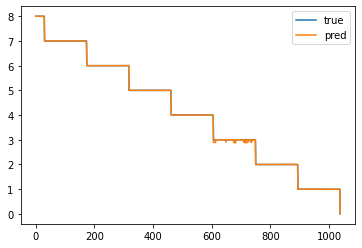

In [ ]:
df_out = pd.DataFrame()
df_out['true'] = np.ravel(y_test.values)
df_out['pred'] = y_pred

df_out.plot()

In [ ]:
import pickle
pickle.dump(rf_xgb, open("xgb_reg.pkl", "wb"))

In [ ]:
import webbrowser
webbrowser.open_new_tab('www.dash-gallery.plotly.host/dash-turbine-maintenance')


False

In [ ]:
from IPython.display import Javascript
def open_web():
    url = 'https://www.dash-gallery.plotly.host/dash-turbine-maintenance/'
    display(Javascript('window.open("{url}");'.format(url=url)))

In [ ]:
%%javascript
window.open('https://dash-gallery.plotly.host/dash-turbine-maintenance', '_blank');

<IPython.core.display.Javascript object>

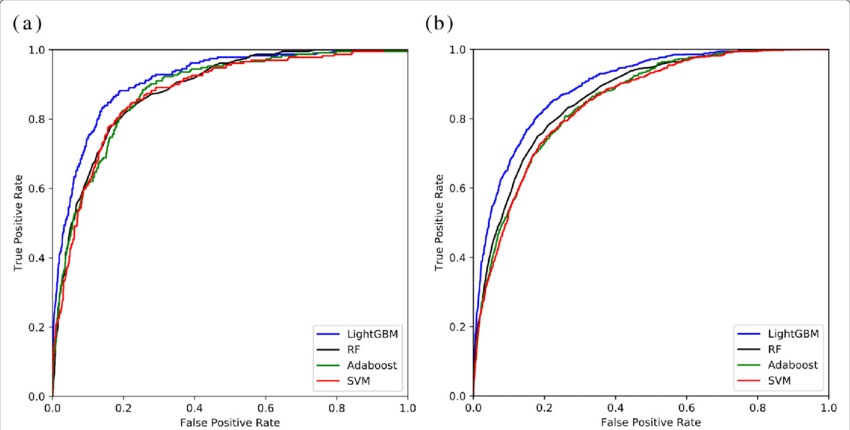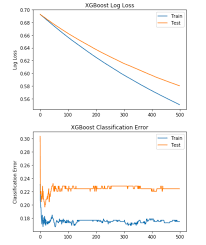

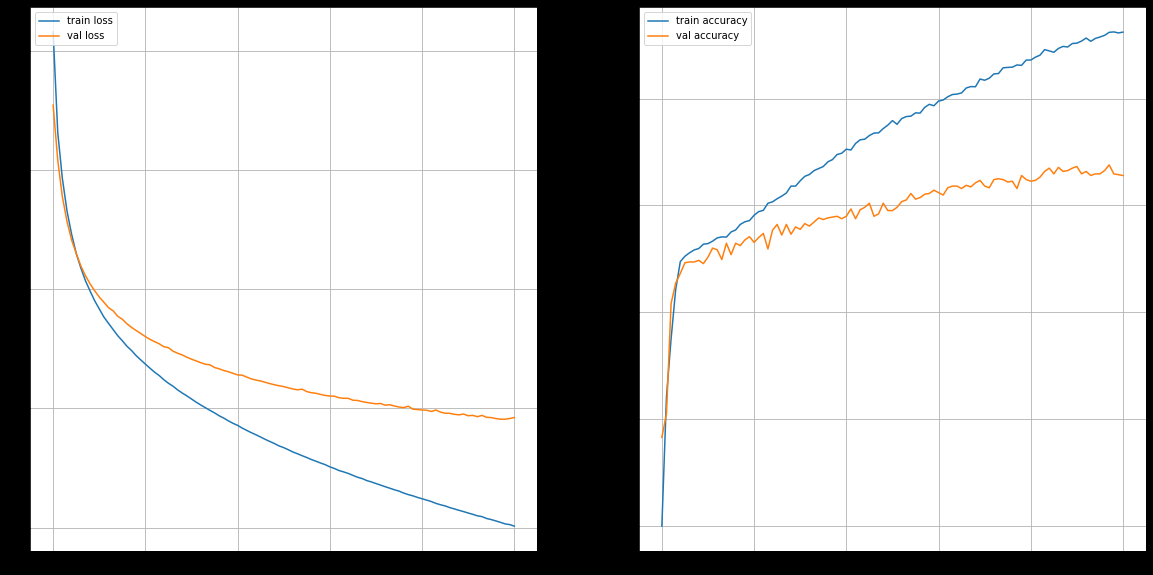

[[1018  134]
 [ 193  965]]


Classification report:

              precision    recall  f1-score   support

           0       0.88      0.84      0.86      1211
           1       0.83      0.88      0.86      1099

    accuracy                           0.86      2310
   macro avg       0.86      0.86      0.86      2310
weighted avg       0.86      0.86      0.86      2310